# **Redes Neuronales en Grafos**

Basado en: https://web.stanford.edu/class/cs224w/ usando [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/).

### **PyTorch Geometric**




In [1]:
import torch
%matplotlib inline
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
torch.__version__

'2.3.0+cu121'

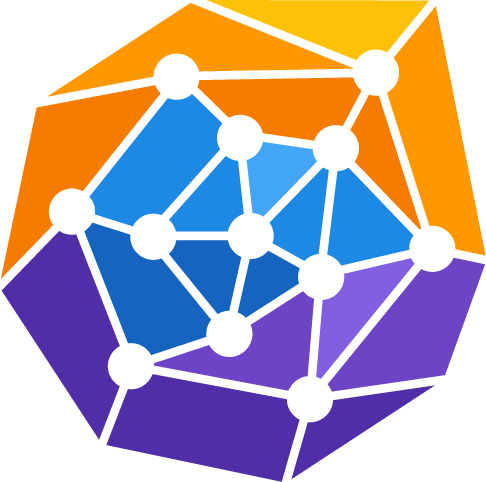

PyTorch Geometric (PyG) es una extensión de PyTorch. Permite trabajar con Graph Neural Networks. Tomado de https://web.stanford.edu/class/cs224w/ basado en el tutorial de [Matthias Fey](https://rusty1s.github.io/#/).

## Instalar dependencias

Ver más sobre el proceso de [instalación](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html). _Nota: Podría demorar significativamente_

In [2]:
# Instalar torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


In [3]:
# @title Helper - Visualización
def visualize(h, color, epoch=None, loss=None, accuracy=None, save=False, do_plot=True):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Época: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Accuracy-Entrenamiento: {accuracy["train"]*100:.2f}% \n'
                       f'Accuracy-Validación: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    if epoch is not None and save:
      plt.savefig("viz_{}.jpg".format(str(epoch).zfill(4)))
    if do_plot:
      plt.show()
    else:
      plt.close()

### **Introducción**

Trabajaremos con [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) -- el objetivo es detectar comunicades que surgen la interacción de los miembros del club.


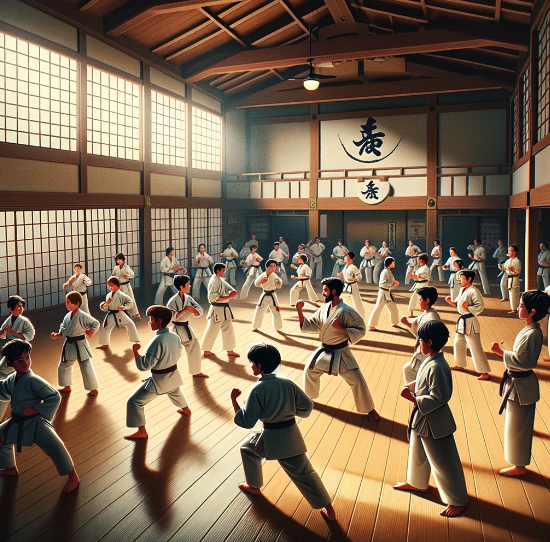

## Dataset

Obtendremos los datos de [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)

In [4]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'# grafos: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# clases: {dataset.num_classes}')

# grafos: 1
# features: 34
# clases: 4


**Propiedades**

In [5]:
data = dataset[0]
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'# Nodos: {data.num_nodes}')
print(f'# Aristas: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contiene nodos aislados: {data.has_isolated_nodes()}')
print(f'Contiene auto-loops: {data.has_self_loops()}')
print(f'Es no-dirigido: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
# Nodos: 34
# Aristas: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contiene nodos aislados: False
Contiene auto-loops: False
Es no-dirigido: True


In [6]:
data.edge_index.T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

## Data

Cada grafo en PyTorch Geometric está representado por un solo objeto de tipo [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data), el cual contiene toda la información para describir su representación del grafo. Podemos imprimir el objeto de datos en cualquier momento mediante `print(data)` para recibir un breve resumen sobre sus atributos y sus formas:

```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```

Podemos ver que este objeto `data` contiene 4 atributos:
(1) La propiedad `edge_index` contiene la información sobre la **conectividad del grafo**, *es decir*, una tupla de índices de nodos de origen y destino para cada arista.
PyG se refiere además a (2) **características de los nodos** como `x` (a cada uno de los 34 nodos se le asigna un vector de características de 34 dimensiones), y a (3) **etiquetas de los nodos** como `y` (a cada nodo se le asigna exactamente una clase).
(4) También existe un atributo adicional llamado `train_mask`, que describe para qué nodos ya conocemos sus asignaciones de comunidad.
En total, solo conocemos las etiquetas de verdad fundamentales de 4 nodos (uno por cada comunidad), y la tarea es inferir la asignación de comunidad para los nodos restantes.

El objeto `data` también proporciona algunas **utilidades** para inferir algunas propiedades básicas del grafo subyacente.
Por ejemplo, podemos inferir fácilmente si existen nodos aislados en el grafo (*es decir*, no existe ninguna arista a ningún nodo), si el grafo contiene bucles propios (*es decir*, $(v, v) \in \mathbb{E}$), o si el grafo es no dirigido (*es decir*, para cada arista $(v, w) \in \mathbb{E}$ también existe la arista $(w, v) \in \mathbb{E}$).

In [7]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


## Edge Index

Vamos a imprimir los `edge_index` de nuestro grafo:

In [8]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

Al imprimir `edge_index`, podemos entender mejor cómo PyG representa internamente la conectividad de un grafo.
Podemos ver que para cada arista, `edge_index` contiene una tupla de dos índices de nodos, donde el primer valor describe el índice del nodo de origen y el segundo valor describe el índice del nodo de destino de una arista.

Esta representación es conocida como el **formato COO (formato de coordenadas)** comúnmente utilizado para representar matrices dispersas.
En lugar de mantener la información de adyacencia en una representación densa $\mathbf{A} \in \{ 0, 1 \}^{|\mathbb{V}| \times |\mathbb{V}|}$, PyG representa los grafos de manera dispersa, lo que se refiere a solo mantener las coordenadas/valores para los cuales las entradas en $\mathbf{A}$ son distintas de cero.

Podemos visualizar aún más el grafo convirtiéndolo al formato de la biblioteca `networkx`, la cual implementa, además de funcionalidades de manipulación de grafos, poderosas herramientas para la visualización:

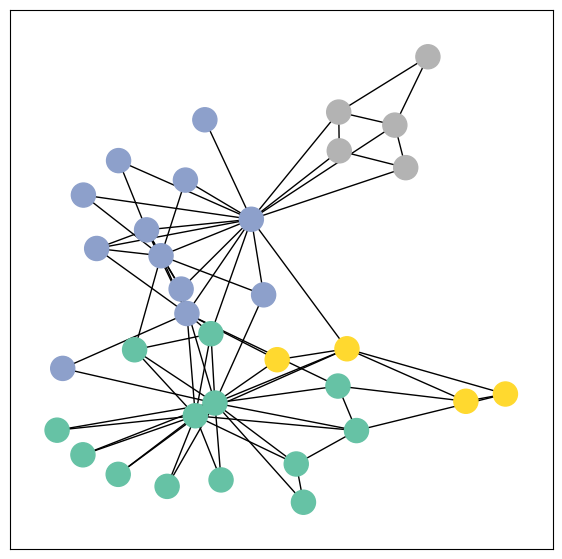

In [9]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

## Implementando Redes Neuronales de Grafos (GNNs)

Después de aprender sobre el manejo de datos de PyG, ¡es hora de implementar nuestra primera GNN! Para esto, utilizaremos uno de los operadores GNN más simples, la **capa GCN** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)). PyG implementa esta capa a través de [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), que puede ejecutarse pasando la representación de características de los nodos `x` y la representación de conectividad del grafo COO `edge_index`.

### ¿Cuál es la salida de una GNN?

El objetivo de una GNN es tomar un grafo de entrada $G = (\mathbb{V}, \mathbb{E})$ donde cada nodo $v_i \in \mathbb{V}$ tiene un vector de características de entrada $X_i^{(0)}$. Lo que queremos aprender es una función $f \to \mathbb{V} \times \mathbb{R}^d$, una función que toma un nodo y su vector de características, así como la estructura del grafo, y produce un _embedding_, un vector que representa ese nodo de una manera útil para nuestra tarea descendente. Una vez que hemos mapeado los nodos y sus características iniciales a sus embeddings aprendidos, podemos usar esos embeddings para realizar una variedad de tareas diferentes, incluyendo regresión/clasificación a nivel de nodo, de arista o de grafo. En este colab, queremos aprender embeddings que serán útiles para clasificar cada nodo en su comunidad. Con esto, estamos listos para crear nuestra primera Red Neuronal Gráfica definiendo nuestra arquitectura de red en una clase `torch.nn.Module`:

In [11]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Aquí, primero inicializamos todos nuestros bloques de construcción en `__init__` y definimos el flujo de cálculo de nuestra red en `forward`.
Primero definimos y apilamos **tres capas de convolución de grafos**. Cada capa corresponde a la agregación de información del vecindario de 1 salto de cada nodo (sus vecinos directos), pero cuando componemos las capas juntas, somos capaces de agregar información del vecindario de 3 saltos de cada nodo (todos los nodos hasta 3 "saltos" de distancia).

Además, las capas `GCNConv` reducen la dimensionalidad de la característica del nodo a $2$, *es decir*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Cada capa `GCNConv` se potencia con una no linealidad [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh).Después de eso, aplicamos una única transformación lineal ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) que actúa como un clasificador para mapear nuestros nodos a 1 de las 4 clases/comunidades. Devolvemos tanto la salida del clasificador final como las incrustaciones de nodos finales producidas por nuestro GNN.Procedemos a inicializar nuestro modelo final a través de `GCN()`, e imprimir nuestro modelo produce un resumen de todos sus sub-módulos utilizados.

Shape: [34, 2]


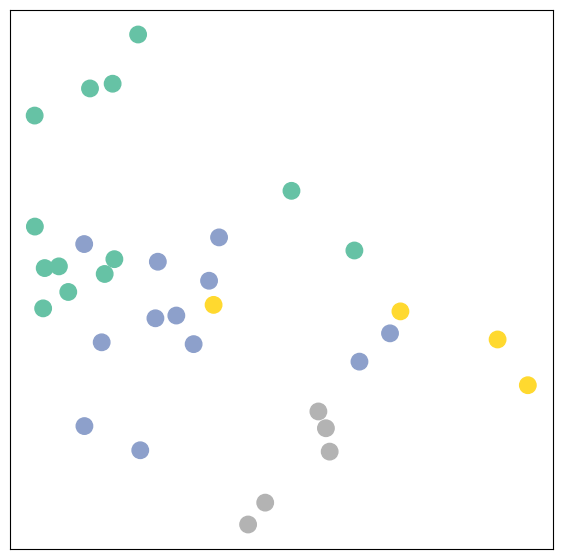

In [12]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Shape: {list(h.shape)}')

visualize(h, color=data.y)

Notablemente, incluso antes de entrenar los pesos de nuestro modelo, el modelo produce una incrustación de nodos que se asemeja estrechamente a la estructura de comunidad del grafo.
¡Los nodos del mismo color (comunidad) ya están estrechamente agrupados juntos en el espacio de incrustación, aunque los pesos de nuestro modelo están inicializados **completamente al azar** y aún no hemos realizado ningún entrenamiento hasta ahora!
Esto lleva a la conclusión de que las GNN introducen un fuerte sesgo inductivo, llevando a incrustaciones similares para nodos que están cerca entre sí en el grafo de entrada.

### Entrenamiento en la Red del Club de Karate

Pero, ¿podemos hacerlo mejor? Veamos un ejemplo de cómo entrenar los parámetros de nuestra red basándonos en el conocimiento de las asignaciones de comunidad de 4 nodos en el grafo (uno para cada comunidad):

Dado que todo en nuestro modelo es diferenciable y parametrizado, podemos añadir algunas etiquetas, entrenar el modelo y observar cómo reaccionan las incrustaciones.
Aquí, hacemos uso de un procedimiento de aprendizaje semisupervisado o transductivo: Simplemente entrenamos contra un nodo por clase, pero se nos permite hacer uso de los datos completos del grafo de entrada.

El entrenamiento de nuestro modelo es muy similar a cualquier otro modelo de PyTorch.
Además de definir la arquitectura de nuestra red, definimos un criterio de pérdida (aquí, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) e inicializamos un optimizador de gradiente estocástico (aquí, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
Después de eso, realizamos múltiples rondas de optimización, donde cada ronda consiste en un paso hacia adelante y otro hacia atrás para calcular los gradientes de nuestros parámetros del modelo con respecto a la pérdida derivada del paso hacia adelante.
Si no eres nuevo en PyTorch, este esquema debería parecerte familiar.
De lo contrario, la documentación de PyTorch proporciona [una buena introducción sobre cómo entrenar una red neuronal en PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Nótese que nuestro escenario de aprendizaje semisupervisado se logra con la siguiente línea:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
Mientras calculamos las incrustaciones de nodos para todos nuestros nodos, **solo hacemos uso de los nodos de entrenamiento para calcular la pérdida**.
Aquí, esto se implementa filtrando la salida del clasificador `out` y las etiquetas de verdad básica `data.y` para contener solo los nodos en el `train_mask`.

Ahora comencemos el entrenamiento y veamos cómo evolucionan nuestras incrustaciones de nodos con el tiempo (mejor experimentado ejecutando explícitamente el código):

In [13]:
# @title Realizar el entrenamiento

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(100):
    loss, h, accuracy = train(data)
    # Visualizar los embeddings
    if epoch % 1 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy, save=True, do_plot=False)


rm: cannot remove 'out.gif': No such file or directory


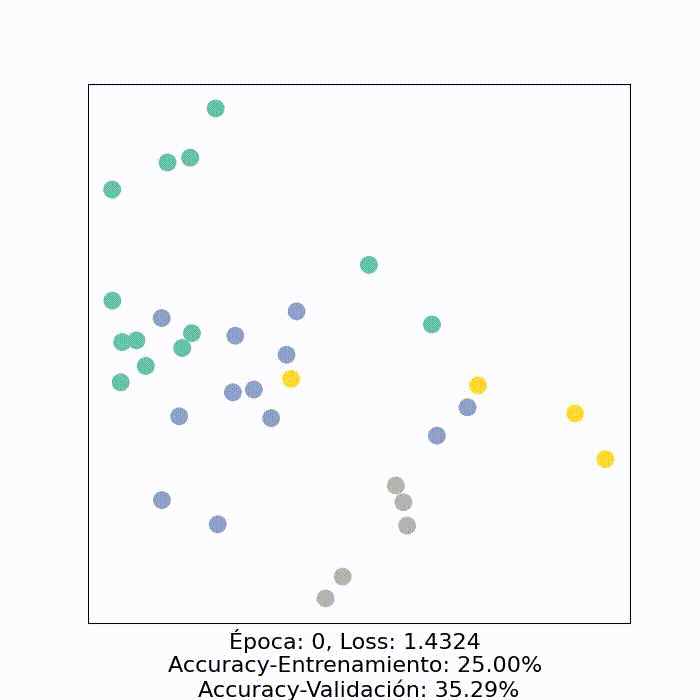

In [14]:
# @title Visualizar
!rm out.gif
!ffmpeg -hide_banner -loglevel error \
  -framerate 5 \
  -pattern_type glob \
  -i '*.jpg' \
  out.gif \
;
!rm *.jpg
Image(open('out.gif','rb').read())

Como se puede ver, nuestro modelo GCN de 3 capas logra separar las comunidades bastante bien y clasificar la mayoría de los nodos correctamente. Además, hicimos todo esto con unas pocas líneas de código, gracias a la biblioteca PyTorch Geometric que nos ayudó con el manejo de datos y las implementaciones de GNN.

## Documentación



Ver más en [documentación](https://pytorch-geometric.readthedocs.io/en/latest/).